In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# read the data
import pandas as pd
import numpy as np

traindf = pd.read_table("gdrive/MyDrive/data/dataset/train.csv", index_col = 0, sep = ",")
testdf = pd.read_table("gdrive/MyDrive/data/dataset/test.csv", index_col = 0, sep = ",")
traindf['total load actual'] = traindf['total load actual'].astype('float64').fillna(method='bfill')


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(traindf['total load actual'].values.reshape(-1,1))
traindf['actual'] = scaler.transform(traindf['total load actual'].values.reshape(-1, 1))
testdf['actual'] = scaler.transform(testdf['total load actual'].values.reshape(-1, 1))

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(traindf['actual'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -19.763150
p-value: 0.000000


In [ ]:
traindf.index = traindf.index.astype("datetime64[ns]")
traindf.index = pd.DatetimeIndex(traindf.index.values,
                               freq=traindf.index.inferred_freq)

# Order of the differencing term (d)

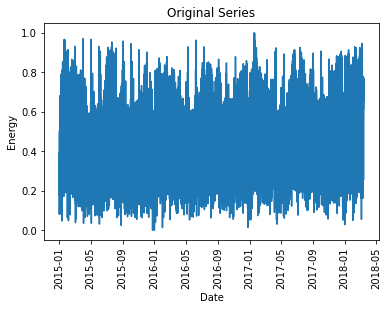

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.plot(traindf['actual'])

# Labelling 
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("Original Series")

# Display
plt.xticks(fontsize=10, rotation=90)
plt.show()

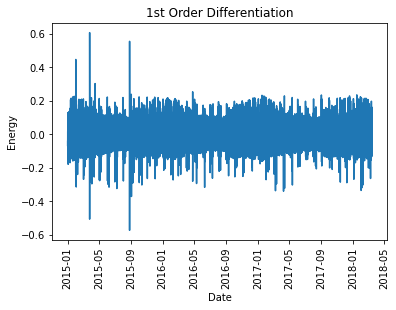

In [ ]:
plt.plot(traindf['actual'].diff())

# Labelling 
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("1st Order Differentiation")

# Display
plt.xticks(fontsize=10, rotation=90)
plt.show()

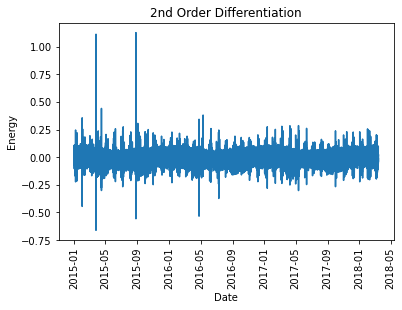

In [ ]:
plt.plot(traindf['actual'].diff().diff())

# Labelling 
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("2nd Order Differentiation")

# Display
plt.xticks(fontsize=10, rotation=90)
plt.show()

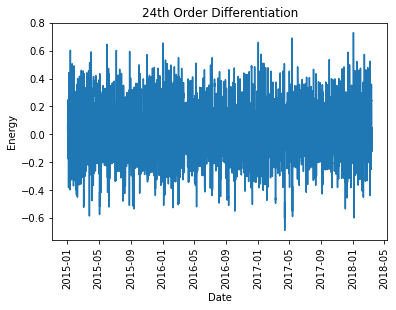

In [ ]:
plt.plot(traindf['actual'].diff(24))

# Labelling 
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("24th Order Differentiation")

# Display
plt.xticks(fontsize=10, rotation=90)
plt.show()

## Order of the AR term (p)

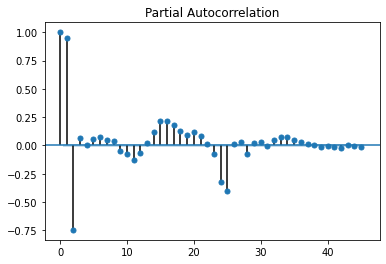

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_pacf(traindf['actual'].dropna())

plt.show()
#Note that the PACF plot has a significant spike only at lag 1, meaning that all the higher-order autocorrelations are effectively explained by the lag-1 autocorrelation.

# Order of the MA term (q)

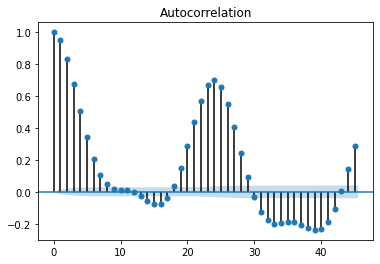

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(traindf['actual'].dropna())

plt.show()

In [ ]:
#If your series is slightly under differenced, adding one or more additional AR terms usually makes it up.
# Likewise, if it is slightly over-differenced, try adding an additional MA term.

# ARIMA model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# p,d,q = 2,1,2 ARIMA Model
#  (P,D,Q,s) order of the seasonal terms
model = ARIMA(traindf['actual'], order=(2,0,4))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 actual   No. Observations:                28051
Model:                     ARMA(2, 4)   Log Likelihood               49843.287
Method:                       css-mle   S.D. of innovations              0.041
Date:                Mon, 23 May 2022   AIC                         -99670.574
Time:                        17:04:10   BIC                         -99604.640
Sample:                    12-31-2014   HQIC                        -99649.351
                         - 03-14-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4622      0.003    147.854      0.000       0.456       0.468
ar.L1.actual     1.5554      0.010    155.220      0.000       1.536       1.575
ar.L2.actual    -0.6634      0.009    -73.24

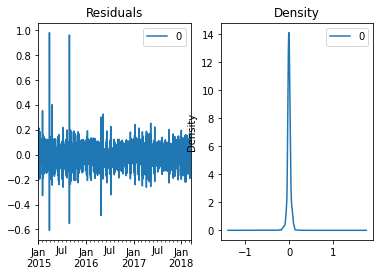

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

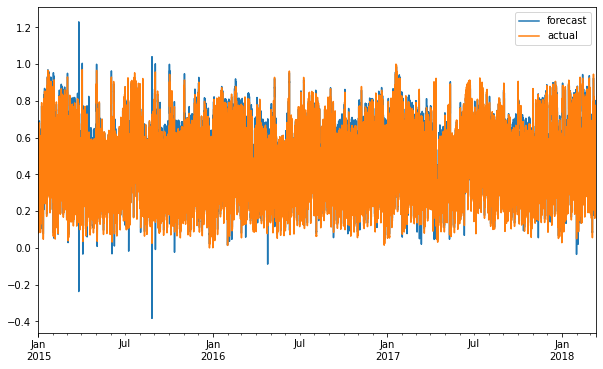

In [ ]:
# Actual vs Fitted
from matplotlib.pyplot import figure

figure = model_fit.plot_predict(dynamic=False)
figure.set_size_inches(10,6)

plt.savefig("gdrive/MyDrive/data/dataset/train_forecast.png", dpi=300)
plt.show()

In [ ]:
history = traindf['actual'].fillna(method='bfill').reset_index(drop = True)
test_act = testdf['actual'].fillna(method='bfill').reset_index(drop = True)
#y_pred = np.full([testdf.shape[0]], None)
y_pred = []

for one_day in range(0, testdf.shape[0], 24):
  model = ARIMA(history, order=(2,0,4))
  model_fit = model.fit()
  day_pred = model_fit.forecast(24)[0]
  #y_pred[one_day:(one_day+24)] = day_pred
  y_pred = np.hstack((y_pred, day_pred))
  #y_pred.append(day_pred)
  #print(len(y_pred))
  history = np.concatenate((history, test_act[one_day:(one_day+24)]))



In [ ]:
len(y_pred)

7032

In [ ]:
testdf['y_pred'] = y_pred[:testdf.shape[0]]

In [ ]:
testdf.to_csv("gdrive/MyDrive/data/dataset/results.csv")

In [ ]:
# Make as pandas series
#fc_series = pd.Series(y_pred, index=testdf.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(testdf['actual'], label='actual')
plt.plot(testdf['y_pred'], label='forecast')

plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(fontsize=10, rotation=90)
#plt.xticks([])
plt.show()

ValueError: ignored

# Metrics

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr})

forecast_accuracy(testdf['y_pred'], testdf['actual'])

{'corr': 0.5789453847866601,
 'mae': 0.16558269457026367,
 'mape': 0.3572969363706275,
 'me': -0.03615759809069868,
 'mpe': 0.08475199093326875,
 'rmse': 0.18143155800824706}

# Auto ARIMA

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 15.9 MB/s 
     |████████████████████████████████| 9.8 MB 54.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(traindf['actual'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=8, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-90662.043, Time=6.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41108.662, Time=1.74 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.57 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4231.305, Time=4.77 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-96380.561, Time=9.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-95635.409, Time=1.26 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-98632.463, Time=15.50 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-96583.715, Time=1.54 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-96419.625, Time=21.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-96529.190, Time=12.86 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-99502.932, Time=55.93 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-99507.068, Time=33.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-91556.068, Time=24.83 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-99390.163, Time=3.91 sec
 ARIMA(2,

In [ ]:
24*365

8760